In [58]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Scalar value function
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

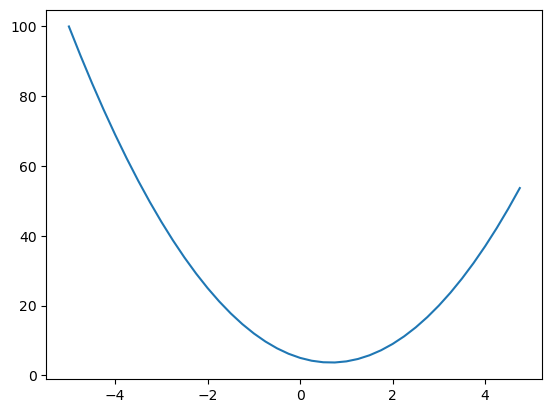

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [16]:
# What is the derivative
h = 0.000001
x = 2/3
# Slope:
(f(x + h) - f(x))/h

2.999378523327323e-06

In [17]:
#lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [20]:
# Try to get the derivative of `d` above
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)



d1 4.0
d2 4.0001
slope 0.9999999999976694


In [153]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other):
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
            
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [140]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [25]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape="record")
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

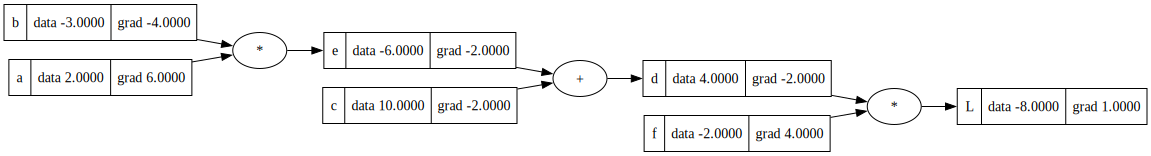

In [53]:
draw_dot(L)

In [56]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad


e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [55]:
def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()

-3.9999999999995595


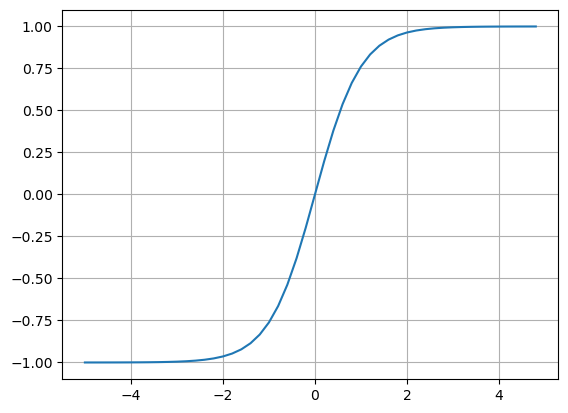

In [59]:
plt.plot(np.arange(-5,5, 0.2), np.tanh(np.arange(-5,5, 0.2))); plt.grid();

In [141]:
# a 2 dimensional neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1';
x2w2 = x2 * w2; x2w2.label = 'x2*w2';

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

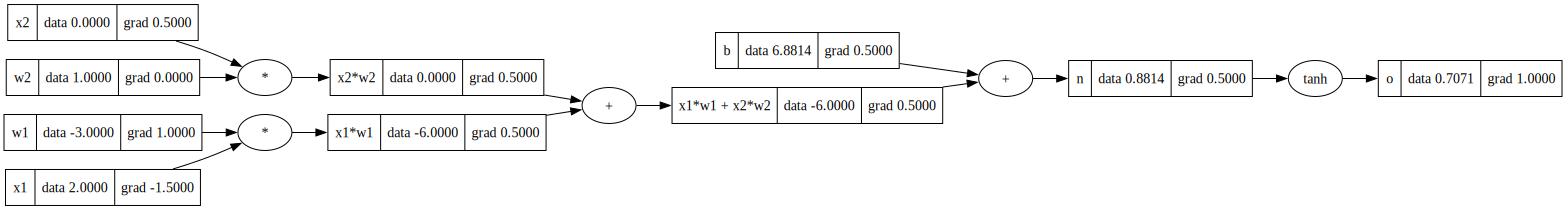

In [142]:
draw_dot(o)

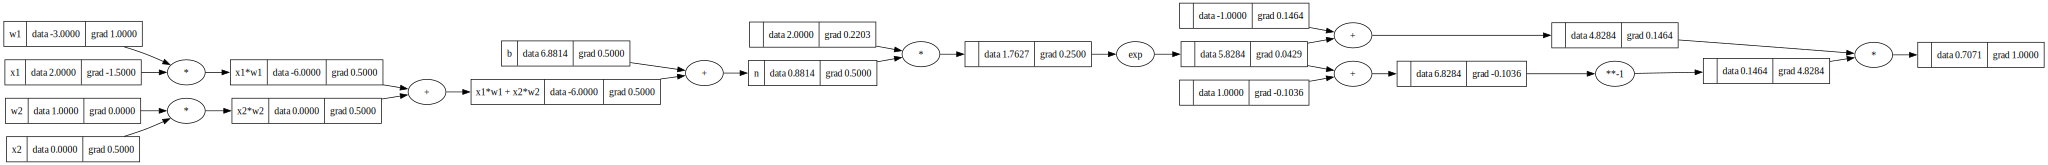

In [143]:
# a 2 dimensional neuron
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1';
x2w2 = x2 * w2; x2w2.label = 'x2*w2';

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---
e = (2*n).exp()
o = (e-1)/(e+1)
o.backward()
draw_dot(o)

In [144]:
# Same neuron as above using pytorch
import torch

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [184]:
import random

class Neuron:
    # Create neuron of a given size with correct number of weights and a bias
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    # When called as a function we have weights paired up with their inputs (x)
    # A forward pass
    # __call__ gets called with the n(x) syntax
    def __call__(self, x):
        # w * x * b
        # Raw activation
        # `sum` takes an optional 2nd parameter which is the start
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # Then needs to be passed to a non-linearity (e.g. tanh)
        out = act.tanh()
        return out

    # return the list of weights concated with bias
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # Nested list comprehension to get all params for all neurons in layer
        return [p for neuron in self.neurons for p in neuron.parameters()]

# MLP: Multi-layer perceptron
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range (len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        


In [264]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.41663950031856756)

In [265]:
n.parameters()

[Value(data=0.902500152040558),
 Value(data=-0.0932339531138362),
 Value(data=-0.6109614993842036),
 Value(data=0.6827481753226967),
 Value(data=-0.0005756643402778927),
 Value(data=0.5210037634252098),
 Value(data=0.5799288629936072),
 Value(data=-0.8145022790331033),
 Value(data=-0.7595724345251953),
 Value(data=-0.7485187596922047),
 Value(data=-0.3307108638566325),
 Value(data=0.37686713049325293),
 Value(data=0.21146571136925374),
 Value(data=-0.7814129235325975),
 Value(data=-0.9699905233605581),
 Value(data=-0.8770785412315225),
 Value(data=0.16664530900527685),
 Value(data=0.14863755912646215),
 Value(data=0.28100431266112125),
 Value(data=-0.7351622041899277),
 Value(data=-0.19772400438671278),
 Value(data=0.7041385098517243),
 Value(data=-0.035752042895700775),
 Value(data=-0.5641117746958082),
 Value(data=-0.12817930690370116),
 Value(data=-0.8786309938341827),
 Value(data=-0.7280424645664396),
 Value(data=-0.9297544525190815),
 Value(data=-0.6229526788718787),
 Value(data=0

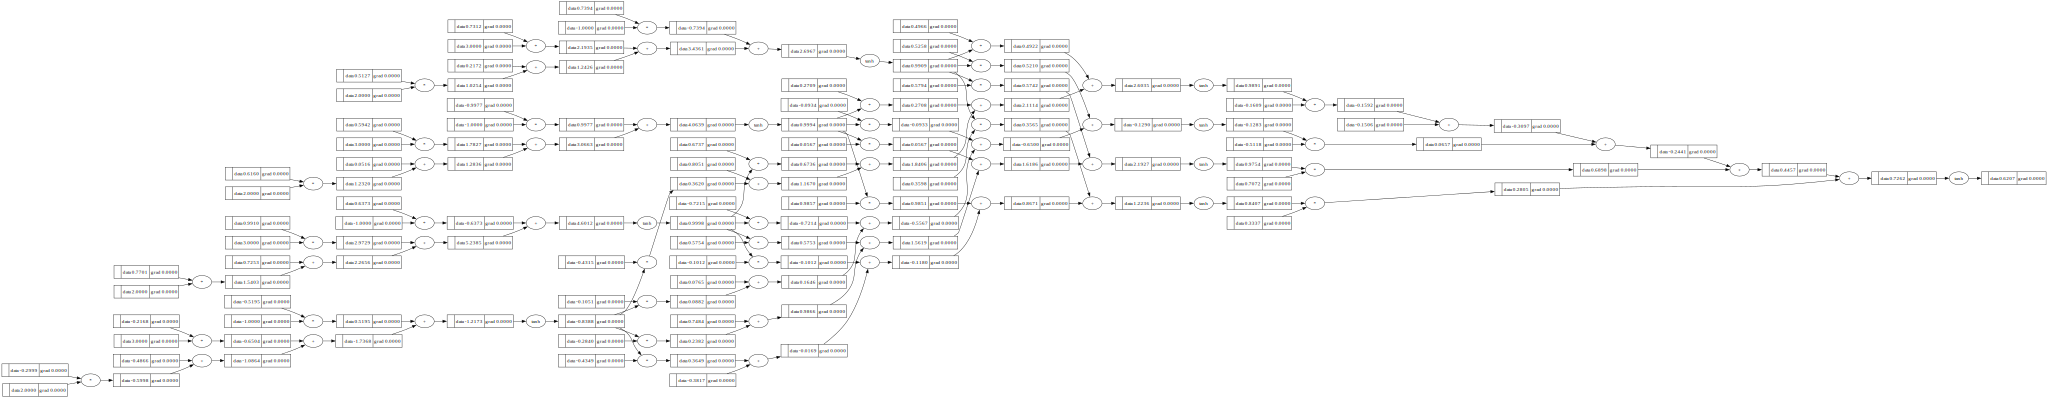

In [173]:
# Draw an entire MLP
draw_dot(n(x))

In [189]:
# Example of a binary classifier
# inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]



[Value(data=-0.9736222100340063),
 Value(data=-0.9515438674946524),
 Value(data=-0.9553296155977823),
 Value(data=-0.9556781593582059)]

In [282]:
# Training loop
for k in range(20):
    # Gradient Descent part 1: forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Gradient Descent part 2: backward pass
    # First reset the grads to 0 so we can correctly accumulate the loss
    # Called `zero_grad` in pytorch
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Gradient Descent part 3: update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.001781698363848372
1 0.0017648208534232525
2 0.0017482565012112263
3 0.0017319967036443843
4 0.0017160331689314128
5 0.0017003579030736246
6 0.0016849631966267614
7 0.0016698416121623452
8 0.0016549859723859793
9 0.001640389348872741
10 0.0016260450513825924
11 0.00161194661772137
12 0.001598087804114951
13 0.0015844625760667586
14 0.0015710650996703822
15 0.0015578897333512216
16 0.0015449310200125507
17 0.0015321836795630917
18 0.0015196426018047912
19 0.0015073028396605345


In [283]:
ypred

[Value(data=0.9834599756266806),
 Value(data=-0.9852311913630283),
 Value(data=-0.9794543200376454),
 Value(data=0.9756383957892846)]

In [190]:
# Output of our nn for above examples
ypred = [n(x) for x in xs]
ypred
# mean squared error loss
# interate for y ground truth and youtput in pred
# Squaring ensures we get a positive number regardless of whether we are more positive or more negative
# I.e. we need to discard the sign
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.724205130950233)

In [256]:
# Gradient Descent part 1: forward pass
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0985617956006939)

In [254]:
# Gradient Descent part 2: backward pass
loss.backward()

In [255]:
# Gradient Descent part 3: update
for p in n.parameters():
    p.data += -0.1 * p.grad

In [257]:
ypred

[Value(data=0.9999898031552023),
 Value(data=-0.965027386902978),
 Value(data=-0.6880084747476612),
 Value(data=0.9999992231282613)]

In [284]:
n.parameters()

[Value(data=0.8080878225807943),
 Value(data=-0.2895925031180171),
 Value(data=-0.857832575711305),
 Value(data=0.473729805950852),
 Value(data=-0.11345817726570223),
 Value(data=0.45492219696480124),
 Value(data=0.39849349290945546),
 Value(data=-0.9562110520977785),
 Value(data=-0.3006002887676624),
 Value(data=-0.9465393050310363),
 Value(data=0.1825622538633582),
 Value(data=0.5616701901551544),
 Value(data=0.11958764521934057),
 Value(data=-0.015384381040015117),
 Value(data=-1.4801705847223954),
 Value(data=-0.6828870703416227),
 Value(data=0.07410557679925671),
 Value(data=0.12935513075728633),
 Value(data=0.3435110052812557),
 Value(data=-0.8079312582038347),
 Value(data=-0.21586493290979705),
 Value(data=1.0011069777373696),
 Value(data=-0.01289409726895168),
 Value(data=-0.7538286226024942),
 Value(data=0.16138397482801478),
 Value(data=-0.8191599271004483),
 Value(data=-0.6280056772493287),
 Value(data=-0.9336719145110255),
 Value(data=-0.6859579948501338),
 Value(data=1.070